Saving wind_tunnel_data.csv to wind_tunnel_data (10).csv


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


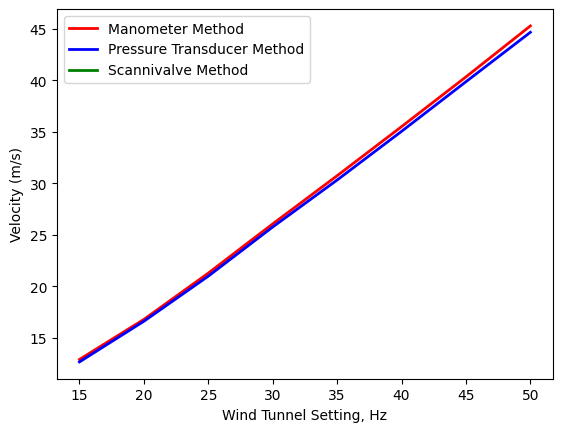

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from google.colab import files  # Import the files module

# Upload the CSV file (wind_tunnel_data.csv)
uploaded = files.upload()

# Use the uploaded file's content as a DataFrame
data = pd.read_csv('wind_tunnel_data.csv')  # Use the correct filename

# Define constants and instrument uncertainties
U_AbsPre = 0.1  # Uncertainty Abs Pressure Transducer kPa
U_D = 1  # Uncertainty Digital Thermometer
U_Pre = 0.01  # Uncertainty_PressureTransducer
U_M = 0.005  # Uncertainty Manometer
U_S = 0.005  # Uncertainty Scannivalve
Fan_Freq = 1000 * 9.806 * 1 * 0.0254  # Fan Frequency Conversion Factor
AreaRatio_A1A2 = 6.25  # area ratio A1/A2

# Extract data columns
T_S = data['Wind Tunnel Setting (Hz)']
M_Head = data['Manonometer (in. of H20)']
PreT_Volt = data['Pressure Transducer (V)']
S_Volt = data['Scannivalve Reading (V)']
Velocity = data['Velocity (m/s)']

# Part 1: Measuring atmospheric pressure & density
Abs_Pr = 96.4  # kPa, absolute pressure
WindT_Temp = data['Air Temperature (degree C)'] + 273.15  # K, Wind tunnel temperature
M_Bias = 0  # 0.129; inch H2O, bias for manometer
R = 0.287  # Specific Gas Constant kJ/kgK

# Calculations
# Part 1
Air_Den = Abs_Pr / (R * WindT_Temp)
U_AirDen = Air_Den * np.sqrt((U_AbsPre / Abs_Pr)**2 + (U_D / WindT_Temp)**2)

# Part 2 (Pressure Transducer Method)
def linear_fit(x, a, b):
    return a * x + b

params_preT, _ = curve_fit(linear_fit, PreT_Volt, M_Head)
ManometerHead_Fit_PreT = linear_fit(PreT_Volt, *params_preT)

# Part 2 (Scannivalve Method)
params_s, _ = curve_fit(linear_fit, S_Volt, M_Head)
ManometerHead_Fit_S = linear_fit(S_Volt, *params_s)

# Part 3: Wind Tunnel Calibration
# Convert pressure in Pa
StaticPressureDifference = M_Head * Fan_Freq
DynamicPressure_PreT = linear_fit(PreT_Volt, *params_preT) * Fan_Freq
DynamicPressure_S = linear_fit(S_Volt, *params_s) * Fan_Freq

# Calculate velocity in m/s
Velocity_Manometer = np.sqrt(2 * StaticPressureDifference / Air_Den / (1 - 1/AreaRatio_A1A2**2))
Velocity_PressureTransducer = np.sqrt(2 * DynamicPressure_PreT / Air_Den)
Velocity_Scannivalve = np.sqrt(-2 * DynamicPressure_S / Air_Den / (1 - 1/AreaRatio_A1A2**2))

# Calculate uncertainty for calculated velocity
Uncertainty_Velocity_Manometer = Velocity_Manometer * np.sqrt((U_M / 2 / M_Head)**2 + (U_AirDen / 2 / Air_Den)**2)
Uncertainty_Velocity_PressureTransducer = Velocity_PressureTransducer * np.sqrt((U_Pre / 2 / PreT_Volt)**2 + (U_AirDen / 2 / Air_Den)**2)
Uncertainty_Velocity_Scannivalve = Velocity_Scannivalve * np.sqrt((U_S / 2 / S_Volt)**2 + (U_AirDen / 2 / Air_Den)**2)

# Plot test section velocity after calibration
plt.figure()
plt.plot(T_S, Velocity_Manometer, 'r-', label='Manometer Method', linewidth=2)
plt.plot(T_S, Velocity_PressureTransducer, 'b-', label='Pressure Transducer Method', linewidth=2)
plt.plot(T_S, Velocity_Scannivalve, 'g-', label='Scannivalve Method', linewidth=2)
plt.xlabel('Wind Tunnel Setting, Hz')
plt.ylabel('Velocity (m/s)')
plt.legend()
plt.show()
